# 📓 Notebook - Teori & Praktik Bab 7: Ensemble Learning & Random Forests

Selamat datang di Bab 7! Di sini akan mempelajari **Ensemble Learning**.

Konsep dasarnya adalah **"Wisdom of the Crowd"**. Jika ingin menggabungkan prediksi dari sekumpulan pengklasifikasi (misalnya: Logistic Regression, SVM, dan Decision Tree), hasil gabungannya seringkali lebih baik daripada hasil dari pengklasifikasi terbaik sendirian.

Bab 7 akan membahas:
1.  **Voting Classifiers** (Hard & Soft Voting)
2.  **Bagging & Pasting** (Bootstrap Aggregating)
3.  **Random Forests**
4.  **Boosting** (AdaBoost & Gradient Boosting)
5.  **Stacking**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=alpha, cmap="Pastel2")
    if contour:
        plt.contour(x1, x2, y_pred, alpha=0.8, cmap="Greys")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", alpha=0.6)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", alpha=0.6)
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

## 1. Voting Classifiers

### Teori
Bayangkan Anda melatih beberapa model berbeda: Logistic Regression, SVM, dan Random Forest. 

Ada dua cara untuk menggabungkan hasil prediksi mereka:
1.  **Hard Voting (Mayoritas):** Setiap model memberikan suara untuk satu kelas. Kelas yang mendapatkan suara terbanyak menjadi prediksi akhir. Contoh: Jika 2 model bilang "Kelas A" dan 1 model bilang "Kelas B", maka hasilnya "Kelas A".
2.  **Soft Voting (Rata-rata Probabilitas):** Jika semua model dapat memprediksi probabilitas (memiliki metode `predict_proba`), kita bisa merata-ratakan probabilitas untuk setiap kelas dan memilih kelas dengan rata-rata tertinggi. Soft Voting seringkali **lebih akurat** daripada Hard Voting karena memberikan bobot lebih pada suara yang sangat yakin.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft' 
)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred):.3f}")

# Insight: Biasanya, VotingClassifier akan memiliki akurasi lebih tinggi 
# daripada model individu terbaik.

LogisticRegression: 0.864
DecisionTreeClassifier: 0.856
SVC: 0.896
VotingClassifier: 0.912


## 2. Bagging dan Pasting

### Teori
Alih-alih menggunakan algoritma yang *berbeda*, bagaimana jika kita menggunakan algoritma yang **sama** tetapi melatihnya pada **subset data latih yang berbeda**?

Ada dua metode pengambilan sampel data:
1.  **Bagging (Bootstrap Aggregating):** Pengambilan sampel **dengan pengembalian** (*with replacement*). Artinya, satu data bisa muncul berkali-kali dalam satu subset model.
2.  **Pasting:** Pengambilan sampel **tanpa pengembalian** (*without replacement*).

Bagging biasanya lebih disukai karena menghasilkan model yang lebih beragam dan mengurangi *variance* (mengurangi overfitting) lebih baik daripada Pasting, meskipun biasnya sedikit lebih tinggi.

Akurasi Bagging: 0.904


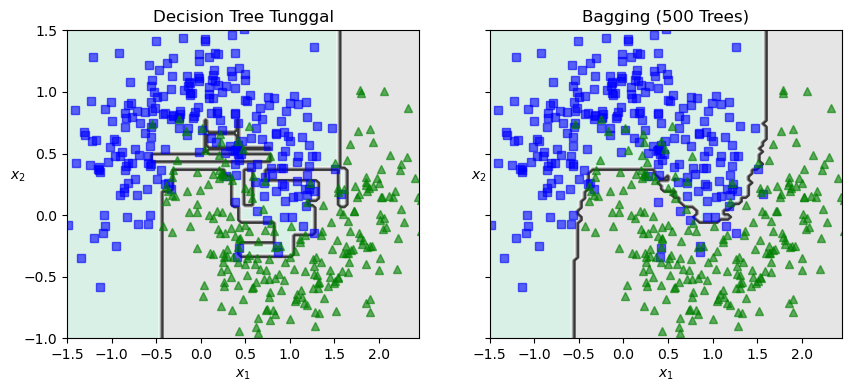

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(f"Akurasi Bagging: {accuracy_score(y_test, y_pred):.3f}")

# Visualisasi perbandingan
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree Tunggal")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Bagging (500 Trees)")
plt.show()

# Insight: Batas keputusan Bagging jauh lebih mulus dan generalisasinya lebih baik 
# daripada satu pohon tunggal.

### Out-of-Bag (OOB) Evaluation

**Teori**
Dalam Bagging, karena sampling dilakukan *dengan pengembalian*, rata-rata hanya sekitar 63% data latih yang dilihat oleh setiap model. Sisa 37%-nya disebut data **Out-of-Bag (OOB)**.

Karena model tidak pernah melihat data OOB selama pelatihan, kita bisa menggunakan data OOB ini sebagai **validasi set**. Kita tidak perlu memisahkan validasi set secara manual! Rata-rata evaluasi OOB dari semua model biasanya mendekati akurasi pada test set.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True, 
    n_jobs=-1,
    random_state=40
)
bag_clf.fit(X_train, y_train)

print(f"OOB Score (Estimasi Validasi): {bag_clf.oob_score_:.3f}")

y_pred = bag_clf.predict(X_test)
print(f"Akurasi Test Set Asli: {accuracy_score(y_test, y_pred):.3f}")


OOB Score (Estimasi Validasi): 0.899
Akurasi Test Set Asli: 0.912


## 3. Random Forests

### Teori
**Random Forest** pada dasarnya adalah kumpulan Decision Trees yang dilatih menggunakan metode Bagging (biasanya dengan `max_samples` diatur ke ukuran training set).

Namun, Random Forest memiliki satu trik tambahan untuk menambah keberagaman: 
Saat mencari fitur terbaik untuk membagi (split) sebuah node, Random Forest tidak mencari di *semua* fitur, melainkan hanya mencari di **subset fitur yang dipilih secara acak**. 

Ini membuat pohon-pohon di dalamnya semakin bervariasi (uncorrelated), yang pada akhirnya mengurangi varians model secara keseluruhan dan menghasilkan prediksi yang lebih baik.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(f"Akurasi Random Forest: {accuracy_score(y_test, y_pred_rf):.3f}")

Akurasi Random Forest: 0.912


### Feature Importance (Pentingnya Fitur)

**Teori**
Kualitas hebat lainnya dari Random Forest adalah kemudahannya dalam mengukur pentingnya setiap fitur. 

Scikit-Learn mengukur ini dengan melihat seberapa banyak node pohon yang menggunakan fitur tersebut untuk mengurangi *impurity* (ketidakmurnian). Semakin besar pengurangan impurity yang dihasilkan fitur tersebut (secara rata-rata di semua pohon), semakin penting fitur itu.

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

print("Feature Importances:")
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(f"{name}: {score:.4f}")

# Insight: Petal length & width biasanya jauh lebih penting daripada Sepal length & width.

Feature Importances:
sepal length (cm): 0.1125
sepal width (cm): 0.0231
petal length (cm): 0.4410
petal width (cm): 0.4234


## 4. Boosting

**Teori**
Boosting (Hypothesis Boosting) mengacu pada metode Ensemble yang menggabungkan beberapa *weak learner* menjadi *strong learner* secara **sekuensial** (berurutan). Ide kuncinya adalah: **model baru mencoba memperbaiki kesalahan model sebelumnya.**

Dua metode Boosting yang paling populer adalah AdaBoost dan Gradient Boosting.

### 4.1 AdaBoost (Adaptive Boosting)

**Teori**
AdaBoost bekerja dengan cara memberikan perhatian lebih pada instance yang **salah diklasifikasikan** oleh model sebelumnya.

1.  Latih model pertama.
2.  Tingkatkan bobot data yang salah diprediksi.
3.  Latih model kedua pada data dengan bobot baru tersebut.
4.  Ulangi proses ini.

Hasilnya adalah rangkaian model yang berfokus pada kasus-kasus sulit.

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


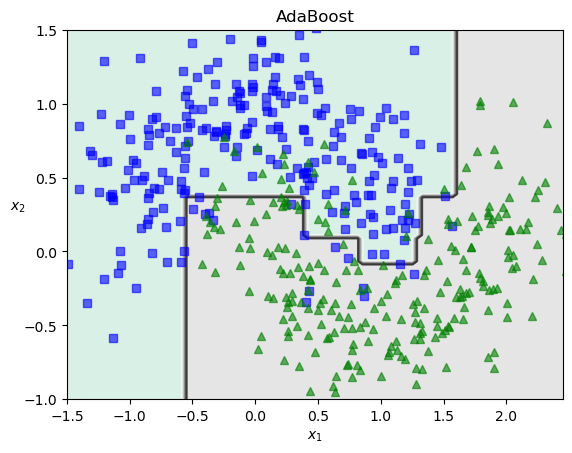

In [9]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost menggunakan Decision Tree yang sangat dangkal (max_depth=1) disebut "Decision Stumps"
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME", 
    learning_rate=0.5, 
    random_state=42
)
ada_clf.fit(X_train, y_train)

plot_decision_boundary(ada_clf, X, y)
plt.title("AdaBoost")
plt.show()

### 4.2 Gradient Boosting

**Teori**
Seperti AdaBoost, Gradient Boosting bekerja secara sekuensial. Namun, alih-alih mengubah bobot data, model baru dilatih untuk memprediksi **residual error** (sisa kesalahan) yang dibuat oleh model sebelumnya.

Contoh:
1.  Model 1 memprediksi data.
2.  Hitung Error (Y_asli - Prediksi_1).
3.  Model 2 dilatih untuk memprediksi Error tersebut.
4.  Prediksi Akhir = Prediksi_1 + Prediksi_2 + ...

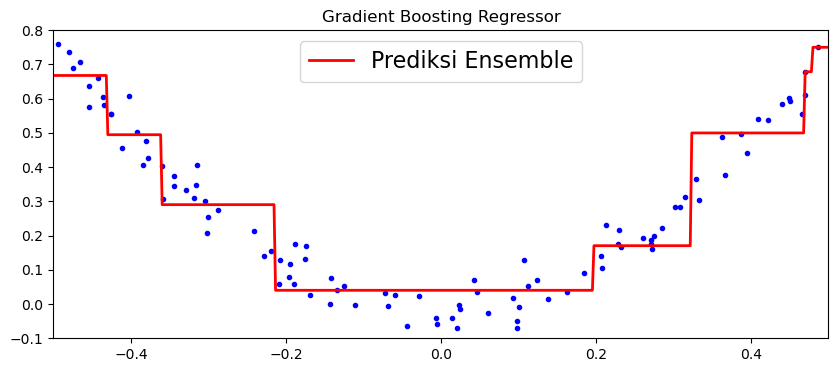

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(42)
X_reg = np.random.rand(100, 1) - 0.5
y_reg = 3*X_reg[:, 0]**2 + 0.05 * np.random.randn(100)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_reg, y_reg)

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(10, 4))
plot_predictions([gbrt], X_reg, y_reg, axes=[-0.5, 0.5, -0.1, 0.8], label="Prediksi Ensemble")
plt.title("Gradient Boosting Regressor")
plt.show()

**Catatan tentang XGBoost:**
Ada versi optimasi dari Gradient Boosting yang sangat terkenal karena kecepatannya dan performanya, yaitu **XGBoost (Extreme Gradient Boosting)**. Ini adalah library terpisah tetapi memiliki API yang mirip dengan Scikit-Learn.

## 5. Stacking (Stacked Generalization)

**Teori**
Metode terakhir adalah Stacking. Ingat pada Voting Classifier kita menggunakan suara mayoritas sederhana untuk menggabungkan prediksi?

Stacking bertanya: "Mengapa tidak melatih sebuah model untuk melakukan penggabungan itu?"

1.  Latih beberapa model dasar (Layer 1).
2.  Gunakan prediksi dari Layer 1 sebagai **input fitur** untuk model baru (Layer 2).
3.  Model Layer 2 (disebut **Blender** atau **Meta-Learner**) belajar memprediksi target akhir berdasarkan prediksi dari Layer 1.

Scikit-Learn menyediakan `StackingClassifier` untuk ini.

In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', SVC(gamma="scale", random_state=42))
]

clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train)
print(f"Akurasi Stacking: {clf.score(X_test, y_test):.3f}")

Akurasi Stacking: 0.896


## Kesimpulan Bab 7

Ensemble Learning adalah teknik yang sangat kuat. 
* Gunakan **Voting** atau **Stacking** untuk menggabungkan model yang berbeda jenis.
* Gunakan **Bagging (Random Forest)** untuk mengurangi varians (overfitting) dan kemudahan paralelisasi.
* Gunakan **Boosting (XGBoost/Gradient Boosting)** untuk mengurangi bias dan seringkali mencapai akurasi tertinggi pada data tabular, meskipun lebih lambat untuk dilatih (karena sekuensial).